<h3> NBA 5 year careeer prediction using XBoost Classifier

In [1]:
import pandas as pd
import numpy as np

<h4> 1. Load processed sets

<h5> Loading scaled training, validation and test sets from data_prep step saved on the data/processed folder saving them into X_train, X_val, y_train, y_val, X_test, X_test_ID variables

In [2]:
#Load Test and validation sets using custom function load_sets
from src.data.sets import load_sets

In [3]:
X_train, X_val, y_train, y_val, X_test, X_test_ID = load_sets()

<h4> 2. Import XGBoost

<h5> Importing and fitting XGBoost Classifier specifying early_stopping_rounds=10 to stop the model after 10 iterations without improving in the predictions, n_estimators=200 and evaluation metric=aucpr to meassure the accuracy of the model vs the validation set

In [4]:
import xgboost as xgb

<h4> 2.1 Analyse features importance in random forest model with current training sets

In [5]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', 
                              #scale_pos_weight=0.1995, 
                              n_estimators=200, seed=42)

In [6]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(xgb_model)
sel.fit(X_train, y_train)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=200, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

<h4> 2.2 Finding the most relevant features in making predictions

<h5> After the model has been fitted, we use get.support to find out which features are most relevant in the predictions

In [7]:
columns = sel.get_support()
columns = columns.tolist()
columns

[True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False]

<h5> As column importance is given in order of appearance on the scaled set, importing column names saved in data_prep for easy visualization and identification will be performed

<h5> Importing predictor column names and combining with relevant columns to find out the best feature predictors

In [8]:
predictors  = pd.read_csv('../data/interim/predictor_names.csv')

In [9]:
predictors['Relevant_Feature'] = columns

In [10]:
predictors

,names,Relevant_Feature
0,GP,True
1,MIN,False
2,PTS,True
3,FGM,False
4,FGA,False
5,FG%,False
6,3P Made,False
7,3PA,False
8,3P%,True
9,FTM,True


In [11]:
predictors.loc[predictors['Relevant_Feature'] == 1]

,names,Relevant_Feature
0,GP,True
2,PTS,True
8,3P%,True
9,FTM,True
12,OREB,True
16,STL,True


<h5> <b>CONCLUSION ON PREDICTORS: </b> Based on the rebalanced training set from data_prep, 6 features are the most relevant predictors. Therefore new data prep will be generated for usage of these columns within the model

<h4> 2.3 New data prep to be performed and data sets saved in the ../data/interim folder

<h5> 2.3.1 Get a list of column names to be removed from data set

In [12]:
columns_to_remove_df = predictors.loc[predictors['Relevant_Feature'] == 0]

In [13]:
columns_to_remove = columns_to_remove_df.pop("names")

In [14]:
columns_to_remove_list = columns_to_remove.values.tolist()

<h5> 2.3.2 Read csvs and remove unwanted columns

In [15]:
df = pd.read_csv('../data/raw/2022_train.csv')

In [16]:
df_cleaned = df.copy()
df_cleaned.drop("Id", axis=1, inplace=True)

In [17]:
# Remove columns with low predictor power training set

In [18]:
#df_cleaned.drop(columns=columns_to_remove_list, axis=1, inplace=True)

In [19]:
df_cleaned.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


<h5> 2.3.3 Rebalance imbalance set with custom function

<h5> This function will undersample the mayority class to have the same number of observations of the minority class. <br> <br> This function is saved in the src folder

In [20]:
from src.data.sets import rebalance_mayority_class

In [21]:
df_rebalanced = df_cleaned.copy()

In [22]:
#df_rebalanced = rebalance_mayority_class(df_cleaned, "TARGET_5Yrs")

<h5> 2.3.4 Scaling and generating training and validation set

<h5> The rebalanced data set will be split into training and validation set for fitting and evaluation of the XGB classifier model <br><br> The rebalancing will be performed with a custom function saved in the src folder

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
target = df_rebalanced.pop("TARGET_5Yrs")

In [25]:
df_rebalanced_clean = scaler.fit_transform(df_rebalanced)

In [26]:
#Import subset function for getting training and valudation sets
from src.data.sets import subset_x_y

In [27]:
X_train, X_val, y_train, y_val = subset_x_y(df_rebalanced_clean, target, target)

<h5> 2.3.5 Clean, transform and scale Test set

<h5> This step will clean, trasnform and scale the test data set with the same steps from the training set

In [28]:
df_test = pd.read_csv('../data/raw/2022_test.csv')

In [29]:
X_test_ID = df_test.pop('Id')

In [30]:
X_test = df_test.copy()

In [31]:
# Remove columns with low predictor power test set

In [32]:
#X_test.drop(columns=columns_to_remove_list, axis=1, inplace=True)

In [33]:
X_test = scaler.fit_transform(X_test)

<h5> 2.3.6 Save train, evaluate and test sets in ../data/interim folder

<h5> Finally, all cleaned and transfor sets will be saved in the data/interim folder using a custom function saved in the src folder

In [34]:
from src.data.sets import save_sets_interim

In [35]:
save_sets_interim(X_train, X_val, y_train, y_val, X_test, X_test_ID)

<h4> 3 Train XGB Classifier with new calculated training sets

<h5> Next up, the XGB classifier will be imported and trained with the new training set and saved into the models folder

In [36]:
xgb_model.fit(X_train, y_train , early_stopping_rounds=10, 
              eval_metric='aucpr', eval_set=[(X_val,y_val)])

[0]	validation_0-aucpr:0.90808
[1]	validation_0-aucpr:0.91302
[2]	validation_0-aucpr:0.91554
[3]	validation_0-aucpr:0.91604
[4]	validation_0-aucpr:0.91684
[5]	validation_0-aucpr:0.91544
[6]	validation_0-aucpr:0.91493
[7]	validation_0-aucpr:0.91445
[8]	validation_0-aucpr:0.91269
[9]	validation_0-aucpr:0.91289
[10]	validation_0-aucpr:0.91420
[11]	validation_0-aucpr:0.91448
[12]	validation_0-aucpr:0.91365
[13]	validation_0-aucpr:0.91336
[14]	validation_0-aucpr:0.91301


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

<h5> After the model has been fitted, it will be saved in the models folder in case it needs to be re-called on a later process

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
#Save model in the models folder
from joblib import dump
dump(xgb_model, '../models/XGBoost.joblib')

['../models/XGBoost.joblib']

<h4> 3.1 Generate predictions for training and validation sets in order to compare accuracy vs Baseline

<h5> The fitted model will be used to predict the validation set and accuracy willl be calculated to compare vs the baseline

In [39]:
y_val_preds = xgb_model.predict(X_val)

In [40]:
y_trainpreds = xgb_model.predict(X_train)

In [41]:
accuracy = accuracy_score(y_val, y_val_preds)
accuracy

0.83625

<h4> 3.2 Calculate mse and mae to assess fiting accuracy for the training and validation sets

In [42]:
#Get error/score metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [43]:
print(mse(y_train, y_trainpreds, squared=False))
print(mae(y_train, y_trainpreds))

0.38426065372348495
0.14765625


In [44]:
print(mse(y_val, y_val_preds, squared=False))
print(mae(y_val, y_val_preds))

0.4046603514059661
0.16375


In [45]:
xgb_model.score(X_train, y_train)

0.85234375

In [46]:
xgb_model.score(X_val, y_val)

0.83625

<h4> 3 Analysis of the validation set

<h5> Analysis of the results will be done through a confusion matrix to gather insights as to where the accuracy/innacuracy exists in order to improve the model in future experiments

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

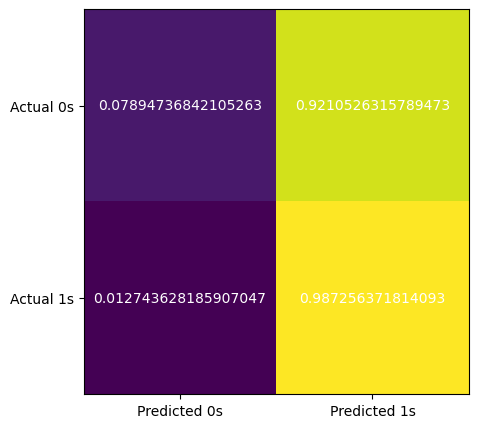

In [48]:
cm = confusion_matrix(y_val, y_val_preds, normalize='true')

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

<h4> 4 Generate predictions on the test set for Kaggle submission

<h5> The final step is to generate the prediction probabilities from the test set in order to evaluate the score from Kaggle via csv upload

In [49]:
y_test_preds = xgb_model.predict_proba(X_test)

In [50]:
#Create Data Frame for Doc printing
df =pd.DataFrame()

In [51]:
y_test_preds


array([[0.20982146, 0.79017854],
       [0.25563145, 0.74436855],
       [0.13811415, 0.86188585],
       ...,
       [0.39827383, 0.6017262 ],
       [0.14545077, 0.8545492 ],
       [0.22032571, 0.7796743 ]], dtype=float32)

In [52]:
target_prob = y_test_preds
target_prob = [item[1] for item in y_test_preds]

In [53]:
df['Id'] = X_test_ID
df['TARGET_5Yrs'] = target_prob

In [54]:
df.head()

,Id,TARGET_5Yrs
0,0,0.790179
1,1,0.744369
2,2,0.861886
3,3,0.802206
4,4,0.720138


In [55]:
#Saving predictions into csv
df.to_csv('../data/external/Kaggle_submission_XGBoost_all_columns.csv', index=False)